In [3]:
import pandas as pd
import numpy as np
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, mean_absolute_error

import xgboost
import numerapi
NAPI = numerapi.NumerAPI(verbosity="info")
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from bayes_opt import BayesianOptimization
import os
import uuid
import pickle
from sklearn.decomposition import PCA

from helpers.utils import *
from helpers.xgboost_feval import *
DIR = "/Users/brianbroeking/projects/numerai/data"

In [4]:
# Download, unzip and load data
download_current_data(DIR)
train_static, val_static, tournament_static = load_data(DIR, reduce_memory=True)
features_list = generate_features_list(train_static)
# Group stats
train_with_group, val_with_group, tournament_with_group = get_group_stats(train_static), get_group_stats(val_static), get_group_stats(tournament_static)

pca = PCA(0.95, svd_solver='full')
pca.fit(train_with_group[features_list])
res = pca.transform(train_with_group[features_list])

train_with_group_pca = pca.transform(train_with_group[features_list])
val_with_group_pca = pca.transform(val_with_group[features_list])
tournament_with_group_pca = pca.transform(tournament_with_group[features_list])

train_with_group_pca_df = pd.DataFrame(train_with_group_pca)
val_with_group_pca_df = pd.DataFrame(val_with_group_pca)
tournament_with_group_pca_df = pd.DataFrame(tournament_with_group_pca)

pca_train = pd.concat([train_with_group.drop(columns=features_list).reset_index(),
                       train_with_group_pca_df.reset_index()], axis=1)
pca_val = pd.concat([val_with_group.drop(columns=features_list).reset_index(),
                     val_with_group_pca_df.reset_index()], axis=1)
pca_tournament = pd.concat([tournament_with_group.drop(columns=features_list).reset_index(),
                            tournament_with_group_pca_df.reset_index()], axis=1)

pca_train = pca_train.drop(columns=['index'])
pca_val = pca_val.drop(columns=['index'])
pca_tournament = pca_tournament.drop(columns=['index'])

You already have the newest data! Current round is: 260
Loading the data


/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [13]:
def era_boost_train(X, y, era_col, proportion=0.5,
                    trees_per_step=10, num_iters=200,
                    one_shot=False, tree_method='hist',
                    test_model=None, note=None):
    print(f"\n#### Era boost train with proportion {proportion:0.3f} ####\n")
    if note is not None:
        print(note)
    if one_shot:
        trees_per_step = trees_per_step * num_iters
        num_iters=1

    if test_model is None:
        print(f"Train {num_iters} iterations")
        print(f"Train {trees_per_step} rounds per iteration")
    else:
        print("Testing model performance")
    features = X.columns
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    param = {
        'colsample_bytree': 0.1,
        'gamma': 0.1,
        'max_depth': 18,
        'min_child_weight': 19,
        'subsample': 1.0,
        'eta':0.001,
        'verbosity':0,
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': -1,
    }
    for i in range(num_iters):
        print(f"\nIteration {i+1}:\n")
        if test_model is None:
            if i==0:
                model = xgboost.XGBRegressor(**param,
                                             n_estimators=trees_per_step,
                                             n_jobs=-1,
                                             tree_method=tree_method)
                model.fit(X, y)
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        else:
            model = test_model
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            print(spearmanr(era_df["pred"], era_df["target"])[0])
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])[0]
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
    return model


#### Era boost train with proportion 1.000 ####

Train 20 iterations
Train 10 rounds per iteration

Iteration 1:

predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.6210756205055916
0.6205936195566
0.6162543009769744
0.6185387834344732
0.632349711572985
0.5931454444401146
0.6118334187966835
0.6228884693246852
0.6218976381169538
0.5873828410718673
0.6014356242200827
0.6291304803887355
0.6314931663055282
0.601746646114507
0.6006908437705244
0.5875332641401941
0.6043159556520453
0.6033159714318879
0.6028983817861268
0.5905405463064841
0.6030194281913379
0.6096874957317643
0.6076567934701578
0.6195123242627534
0.6179873151473241
0.607921647727456
0.6031253915408081
0.6073506778252998
0.6124441575393331
0.6167474301170397
0.6154752157983268
0.6145759529219609
0.6134008360941989
0.6203984977534608
0.6008035332525012
0.6159407913118681
0.616512493828521
0.6194054060157665
0.6184500106904564
0.6108964528097358
0.6061142363308099
0.6075230365845337
0.6170872473288643
0.5996642959189857
0.614678886450579
0.6098805662753618
0.6033470880083922
0.6211780298283051
0.6263982333683623
0.6202566913484955
0.6157737629690847
0.62490929583684

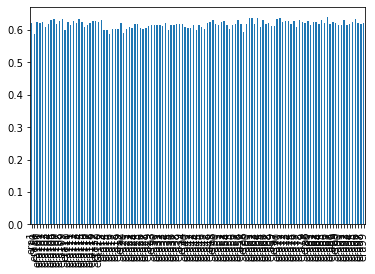

autocorrelation
0.2953523067253547
mean correlation
0.6185950808527835
sharpe
56.99328515900385
smart sharpe
41.97327487050828

Iteration 2:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.7935172992032579
0.786413309705866
0.7924310545828005
0.7922041269876788
0.8038694778988276
0.771080440704454
0.7924009908708745
0.7961642504381305
0.795470910059065
0.7826947202485317
0.7931490706914985
0.7962381368183514
0.8009421502315803
0.7877762480645457
0.7881151217596747
0.7952151208465676
0.789117919296032
0.7838922584328852
0.7868083691759958
0.7917060799662988
0.7811066858142877
0.7948430558690822
0.7922549896724628
0.800623614097077
0.7974279169723901
0.7821416013262646
0.7787394861433452
0.7876750593905565
0.7881415615225791
0.7938316753324691
0.791854568745792
0.7892543442515471
0.7897503706580987
0.792579539535113
0.7945718943486705
0.7965579088087303
0.7965881779614592
0.7983263265109867
0.8003360473364766
0.7880757429109516
0.7872301251973653
0.7830515061588565
0.7922819234629024
0.7861531556355806
0.794063440120209
0.7892729213040148
0.785411930817984
0.7939449038974662
0.8019846732506262
0.7970387687106197
0.7999309429076102
0.801003387270714

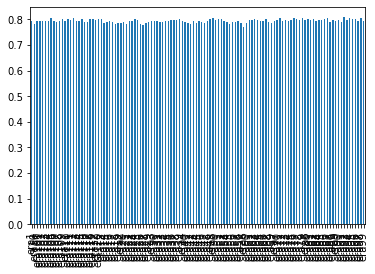

autocorrelation
0.38247259565749686
mean correlation
0.7943286540766711
sharpe
123.74316407574678
smart sharpe
82.66685427019563

Iteration 3:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.865317421649635
0.8604858163522061
0.8580125468132427
0.8614187610096887
0.8646136175349323
0.8519721549093696
0.8619262641831618
0.8666050104906327
0.866782500421405
0.8597529151639693
0.8589427767280567
0.8621163516734451
0.8656759328599772
0.8632568416621986
0.8612590571892453
0.8615344293067121
0.8594833727201681
0.861146459085015
0.858273012487473
0.8626873579907919
0.8501343010729624
0.865216277342587
0.8622601537388819
0.8721087473409715
0.8662601090173454
0.861653277862104
0.8577144343702586
0.8624098085750747
0.8552328595524736
0.8641323585380748
0.8670847982653583
0.8584124939478119
0.8579842944069163
0.8597974844116976
0.8595983806276418
0.8621870334335217
0.8629872013054445
0.865626908133369
0.8670052783571166
0.8628371393640458
0.8563925311670453
0.8558609270282119
0.8649379678359608
0.8607627617089068
0.8665306538658823
0.8634452819432314
0.8593358188093543
0.8623921139392163
0.8659551655797718
0.8643974793787038
0.8649616595404699
0.8662043373458

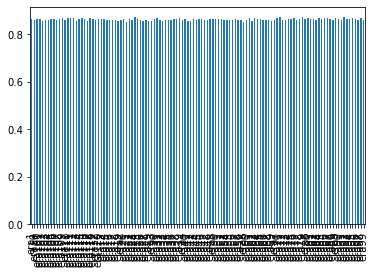

autocorrelation
0.13387440035999437
mean correlation
0.863107493528305
sharpe
208.55411494722338
smart sharpe
181.72032053151196

Iteration 4:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9001920038838747
0.8952453676610322
0.889477340770566
0.8951935764239338
0.893867519656747
0.8895789615364326
0.8938729387234482
0.8991799000731581
0.8958001674856625
0.8960393834786469
0.8928063606100434
0.8940152182013831
0.898965740972137
0.8954073877554793
0.8944306960115148
0.8933804194513778
0.8921201919026072
0.8940558317545906
0.8935349610401924
0.8932530011929969
0.8872939231090508
0.8988506073201155
0.8942291933146325
0.8985879415319437
0.8972451199204675
0.8957726514572293
0.8919286270884714
0.8957368700262216
0.8879024576305127
0.8940077787385344
0.8957608877944612
0.8916635946770209
0.8882122459733681
0.8949291650636653
0.8941490057973466
0.8937834236666433
0.8948956414489403
0.8959493929704094
0.8951703829972363
0.894812426792426
0.8910494853234945
0.8871346128834524
0.8939172088653888
0.8935692860465401
0.8942365347853132
0.8962147816727885
0.8905069162713267
0.8965742294278007
0.8967257571297208
0.8954258488079682
0.8968064602717537
0.8972820789

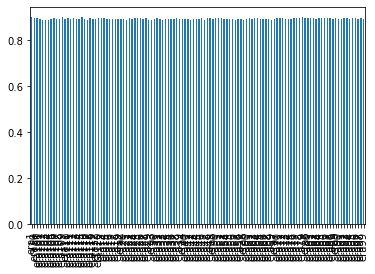

autocorrelation
0.1968028169180403
mean correlation
0.8945661739186442
sharpe
312.2547437155505
smart sharpe
255.17252298466124

Iteration 5:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9138341725271563
0.9102715581335457
0.9056300528064286
0.9113500343242815
0.9083086272725295
0.9084101446266081
0.9094359762664
0.9108001278215115
0.9083474464460854
0.9095140175160717
0.9087243123698201
0.9093747195837882
0.9122944792887098
0.910768721516716
0.9085796702554801
0.909111949307401
0.9074710934608874
0.9073464441863895
0.9103332159863983
0.908479192179051
0.9063541971174072
0.912695993542072
0.9098885113578435
0.9105150188653486
0.910802910263957
0.9095014530249916
0.9069007268891224
0.9089952929729805
0.9063906809549928
0.9090558371202683
0.9105123019442138
0.9062437036944799
0.9052334217077339
0.9094634466002777
0.9086001455849051
0.9078658198843599
0.909526149040416
0.9090120482019046
0.9085091024770588
0.9103343372407904
0.9082773757364041
0.9043599365183488
0.9091301486494714
0.9079275203323548
0.9079811655678932
0.909770187005364
0.9054783771492214
0.9098142921492884
0.9094299029564546
0.9086042062736935
0.9102139702297107
0.9107842370116869

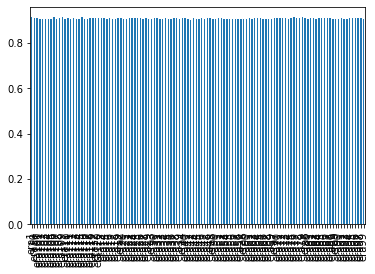

autocorrelation
0.11772978184028975
mean correlation
0.9090464335539639
sharpe
442.173063606573
smart sharpe
391.5976130006252

Iteration 6:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9205070636025174
0.9185461150168123
0.9152468870894829
0.9180602272478927
0.9160444067636943
0.9164798561103803
0.9157932852873572
0.9174897404443862
0.9173137670563183
0.9165158666150495
0.9161083770338914
0.9166779576593853
0.9179177464358349
0.9180438146461048
0.915531052656364
0.9161479523638862
0.9154593028721029
0.9148352880102796
0.9185555312709028
0.9158324351815416
0.9129610293291532
0.9192637999128392
0.916802407314744
0.9166160364776197
0.9173243119294896
0.9161058995642016
0.9152735483263963
0.916238066088341
0.9139930687186193
0.9152149809664702
0.9180640819322415
0.9152302766200239
0.9130409018294798
0.9163326390292327
0.9158738664092105
0.9155421758155704
0.91679665747403
0.9171488544793527
0.9152950440855652
0.9178632434896306
0.9154920058775754
0.9136019704058619
0.9165773273356214
0.9146380522896481
0.9149380088539575
0.9159597306616131
0.9128922044514559
0.9161946677394582
0.9159979284285431
0.9162396358384441
0.9162466300119941
0.91790011921

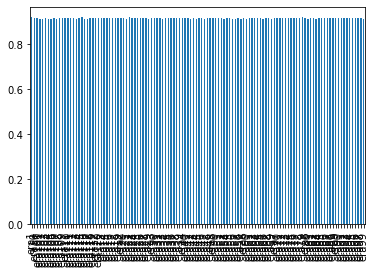

autocorrelation
0.01786046626488676
mean correlation
0.9161357736275766
sharpe
568.6427760046456
smart sharpe
556.3262168025582

Iteration 7:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9232920578419868
0.9210510594489979
0.9192826798057471
0.9213853548345697
0.9202983588167546
0.9199691341323893
0.9190562819568825
0.920243609035116
0.9203599665579983
0.9202798713631936
0.919647320987018
0.9196781375451494
0.9210391562161092
0.9213621207261541
0.9195060756822532
0.9196746101375991
0.9195483936271539
0.9185200831620439
0.9214399271422664
0.9193443077318716
0.9174774271876462
0.9218608911143567
0.9196180104725855
0.9199914987750887
0.9206234914128547
0.9199290951813417
0.9191284607808037
0.9200727593188184
0.9188279093339813
0.918811748219841
0.9212846811079354
0.9183188198773882
0.9174233083168171
0.9198431568597117
0.9191469580476893
0.919233472411479
0.920170367491422
0.9202717137464772
0.9188109596406223
0.9204637287976872
0.919282559965499
0.9176082777904218
0.9198292519062923
0.9185947839824704
0.9181666208987213
0.9190443352131771
0.9172813217690021
0.9194417673938411
0.9191068300465135
0.9199111053523918
0.9197609152193374
0.920730723751

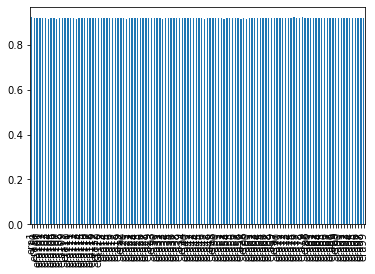

autocorrelation
0.07625597603310921
mean correlation
0.9195677997189083
sharpe
720.5113972844388
smart sharpe
665.1498798785758

Iteration 8:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9241446467330172
0.9226645387555333
0.9212378185701267
0.9227553405080358
0.9221492575464482
0.9221068222959006
0.9208081742210633
0.9217925267648934
0.9222973851265388
0.9214389805421749
0.9213252684474587
0.9220946395886841
0.9220960127520347
0.9232703380816152
0.9214849430403838
0.9217897905655763
0.9213750817094264
0.9197485102831088
0.923150613258121
0.9210491899860574
0.9193230348187555
0.9230552484200945
0.9211317736126261
0.9216055016006053
0.9221620799571496
0.9216047521386814
0.9208475718876181
0.9219724557194421
0.9207467809990765
0.9208904317563051
0.9226543678804218
0.919951429689612
0.9198273823110232
0.9210457793357284
0.9204626572166343
0.9210376605465511
0.9214109782091132
0.9218651243796647
0.9206475398206551
0.9217339149988302
0.9207577195544525
0.9198060412832428
0.921666573612117
0.9205063159977419
0.9195206295597893
0.9205288377479048
0.919686821709672
0.9206738353508395
0.9209675379881961
0.9218061003144157
0.9213097529613077
0.9222287724

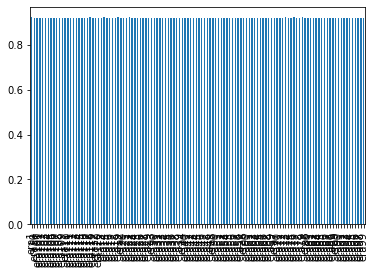

autocorrelation
0.03601501743374262
mean correlation
0.9212108972148841
sharpe
808.5768525811659
smart sharpe
776.9388208883929

Iteration 9:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9246007777217152
0.9234044580047976
0.922338020465165
0.9235880529455294
0.9230494734315677
0.9230133834354758
0.9220634999161107
0.9226555029787825
0.9229419614995231
0.9229221369797419
0.9226399944315485
0.9227348810422973
0.9230903461036888
0.9240607502496366
0.9225819300670299
0.9230572663838605
0.9222625935514963
0.9209063959277763
0.9240216365741025
0.9218873982815143
0.9207307148311492
0.9239954332570565
0.9223517302847145
0.9225252162355722
0.923123293501109
0.9228863690009886
0.9216702062375396
0.9229499494690502
0.9216157122382311
0.921800629580582
0.9232529090828218
0.9211191154941784
0.9207698439731441
0.9221371241180087
0.9211990798270302
0.9221782634931394
0.9220265138763902
0.9227391460244666
0.9218924570690672
0.9225284750701769
0.9216452027957971
0.9207681973745765
0.9223993534155404
0.921778674283191
0.9205578581621369
0.9215878757392325
0.9207621065782441
0.9216191106270681
0.9221124221243026
0.9227408481538082
0.9221983261254432
0.9232008732

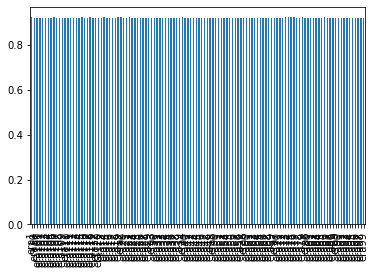

autocorrelation
0.059217002925630036
mean correlation
0.9222011243672997
sharpe
895.4970018381467
smart sharpe
840.8420572469178

Iteration 10:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9251492047846087
0.9240177508348572
0.9230984906597156
0.9240902168276971
0.9238867454595665
0.9234869327743707
0.9227974041971305
0.9233172137960902
0.9234791782660677
0.9237070211629537
0.9232472497987991
0.9233340143117301
0.9236770777827694
0.9244371712586253
0.9229927173589106
0.9235205089873739
0.9226911192564895
0.9218923339722213
0.9244747196054435
0.9228509431738637
0.9218405455120497
0.924531935899333
0.9230124281815207
0.9231665925900138
0.9236104410047524
0.9234564295763606
0.9222664581209599
0.9235035191491455
0.9222714100551302
0.9225680362421557
0.9237567798081738
0.9218575914379491
0.9213602076004398
0.9226120279342075
0.9219320989676859
0.9228549209062182
0.9228572809278209
0.9233605030735971
0.9228621226693328
0.9232369465978543
0.9221256234225313
0.9215634698315982
0.9231122719126954
0.9225694032944347
0.9213630061757143
0.9222819374232258
0.9215334768180953
0.9222940200778876
0.9228315414660296
0.923266655026315
0.9227513200749436
0.92366149

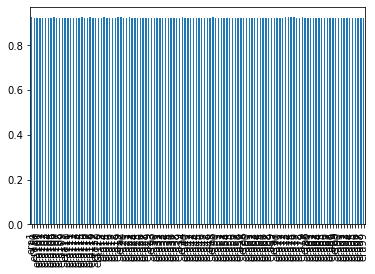

autocorrelation
0.09213933857022265
mean correlation
0.9228350646985142
sharpe
983.8256770721704
smart sharpe
893.9395746006549

Iteration 11:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9253681122139172
0.9243718621714231
0.9235219519269259
0.9243806868513821
0.9244209497340711
0.923740854469519
0.9231907843446167
0.9237356377790726
0.9240449676630736
0.9240902898282536
0.9238320059332782
0.9239712782597963
0.9240373958852823
0.9246777327995095
0.9232780939527757
0.9240422572359637
0.9230867418407304
0.9225114909649319
0.9248290799257247
0.9233221678086718
0.9226163864261641
0.9247373429769021
0.9233644119231574
0.923611357154679
0.9238751148969127
0.92402047223774
0.9226487147429919
0.923800076322033
0.9228449589834637
0.9228207715006042
0.9240504448424637
0.9223895282908351
0.9217122440778024
0.922991018923831
0.9224136323770716
0.923380026368476
0.9233866800596137
0.9237691188995758
0.9232381500321801
0.9234930213691729
0.9225690459190763
0.9221078060990362
0.9236437294169861
0.9229335724155454
0.9217006387163352
0.9227307163888744
0.9219166642878154
0.9227773960013197
0.9231898430785518
0.9236927839492818
0.9232385786043253
0.9239889374861

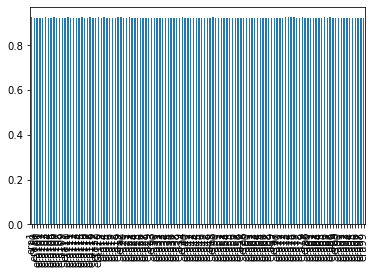

autocorrelation
0.12129621586588202
mean correlation
0.9232750843577041
sharpe
1057.471184354195
smart sharpe
933.1650573150852

Iteration 12:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9255780684616449
0.9246552518066713
0.923858437248107
0.9246869267507916
0.9247872820026173
0.9240659520547904
0.9234652949832437
0.9240563715547155
0.9245002245791759
0.9243753629212675
0.9241340319973298
0.924333867052456
0.9241891810702031
0.9248718285566924
0.9237384962953605
0.9243551258967178
0.9234265186057077
0.9229839573770995
0.9251652277547349
0.9236387384516058
0.9234587324704328
0.9249583339333605
0.923733970588433
0.9240088185393673
0.9242077421595906
0.9242926928716447
0.9231471610628363
0.9241473958536462
0.9231755593010006
0.9232765215855184
0.924295340756728
0.9227992262644951
0.9223002512966272
0.923428546851882
0.9227840209594996
0.9236424331686147
0.9237062670543787
0.9241592475515851
0.9236210691571679
0.9238317707863654
0.922876390218791
0.9226320192027335
0.9240175182426101
0.9233858246160049
0.9222560874360028
0.9229773686114318
0.9223438292248788
0.9229461821223854
0.9236931926490761
0.9239891781561093
0.9236026757020687
0.924184696180

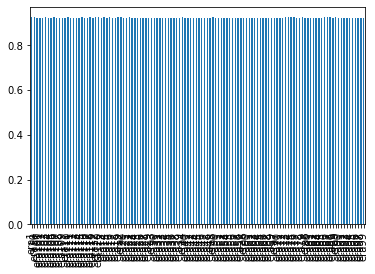

autocorrelation
0.14875948766428324
mean correlation
0.9236316769825057
sharpe
1134.572267605714
smart sharpe
973.8181606727261

Iteration 13:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9256663920168562
0.9248799570247651
0.924004136039576
0.9249434728820511
0.9249268346763379
0.9242346813184678
0.9237489859554702
0.9242382234658848
0.9246676862484257
0.92466525358466
0.9243436575948317
0.9245232578244797
0.9243840990679265
0.9251090278573475
0.9240039961803449
0.9245355009071261
0.9235892705326437
0.923293289097593
0.925353027547157
0.9239711542570056
0.9238285441610427
0.9251723571861362
0.923991185878071
0.9242761334966914
0.9243521400717651
0.9245163933771642
0.9234675209348482
0.9243161693615537
0.9233910416788293
0.9236094645759368
0.9244604074353477
0.923149629889678
0.9224834265604002
0.9236482546393869
0.9229798370916718
0.9239539829541223
0.9239380226228935
0.9243343747896509
0.9239831756906132
0.9239726235511022
0.923216567887006
0.9230424673472917
0.9242699320112584
0.9236914969745077
0.9225591865277585
0.9232248808154143
0.9228232102008159
0.9232098721861303
0.9239062381981623
0.9242625715863674
0.9237956530469815
0.92432347006601

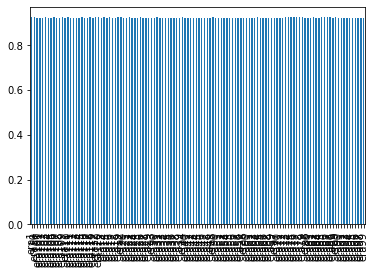

autocorrelation
0.16826758479152962
mean correlation
0.9238908013696014
sharpe
1217.392322396511
smart sharpe
1024.3814337823046

Iteration 14:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9257010448396715
0.9250015643003031
0.9241817775478993
0.9250360647710206
0.9251856935119648
0.9244236759050292
0.9239219371385533
0.9244938847424525
0.924806347931358
0.9247700885925295
0.9244890217109499
0.9246933115642912
0.9244467544414702
0.9252183651890231
0.9242233075855822
0.9246980765639536
0.9237229394028129
0.9235165193906939
0.9254632618835824
0.9241597202613935
0.9239900958264531
0.9252265378317555
0.924147050867561
0.9244597155662536
0.9243944758394746
0.9246965427898987
0.9236434291886044
0.9244243329951023
0.9235779420272807
0.923712097444866
0.9246084018002398
0.9233194325403606
0.9225880636855236
0.9238080043776904
0.9232008176888723
0.9241053468818732
0.9240620429326554
0.9245020853715089
0.9242144514541637
0.9241354226731702
0.9235308287922276
0.9231855623786854
0.9245055830995218
0.9239056338832787
0.9227835044609847
0.9233826607732997
0.9229392390539896
0.9233151629571718
0.924104971188737
0.9244006052130005
0.923994675187866
0.92445929094

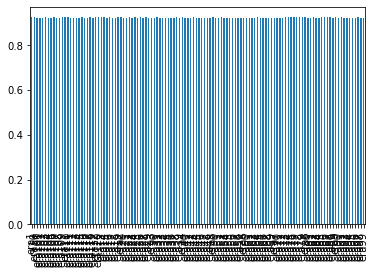

autocorrelation
0.17258878623671906
mean correlation
0.9240684361325272
sharpe
1278.0786270344527
smart sharpe
1070.7128517494455

Iteration 15:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.925763279937296
0.9251575283278223
0.9242362201812367
0.9251767089861825
0.9254052997828658
0.9246588556042133
0.9240772790512222
0.9245979997259588
0.9249231977966016
0.9248894877628575
0.9246193079194645
0.9248687180906376
0.9246038028519526
0.9253205548073525
0.9243658260786126
0.9248367796004817
0.9238194943415455
0.9238088616941553
0.9255753126941691
0.9242092920324757
0.9242064657508785
0.9253797768043399
0.9242764192144283
0.924572544854163
0.9244172417370267
0.9248481133846259
0.923805853517456
0.9245056231388459
0.923697320966458
0.9238441567224085
0.9246949771554912
0.9235116699927887
0.9227214607717449
0.9239806749397564
0.9234037863353975
0.9243169434793985
0.924209892202906
0.9245885234563604
0.9243564219386884
0.9242479212106266
0.9236598910944682
0.9233545091101591
0.9246590650760605
0.9241214389232263
0.923031640090395
0.9235309708058076
0.9230648020318459
0.9235091662588023
0.9242044829184475
0.924583291646201
0.9241183250593304
0.9245629185587

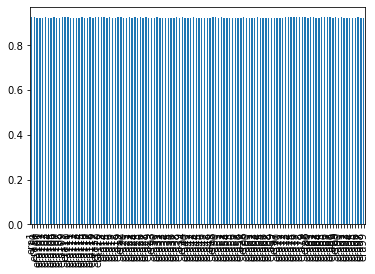

autocorrelation
0.16703973800745908
mean correlation
0.9242211098232223
sharpe
1326.6165414266559
smart sharpe
1117.6874297366167

Iteration 16:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9258688179207443
0.9252997461155975
0.9244137924289425
0.9252350597111504
0.9255234630890298
0.9248433464744669
0.9242061851682137
0.9248398671480066
0.9250151248889835
0.9250493885943454
0.9247410832776395
0.9250000745955015
0.9247188051136501
0.9254204390334664
0.9245498691531823
0.9249158285769774
0.9239855030839716
0.9239175086410243
0.9256880023006763
0.9243895554831744
0.924463182665551
0.9255390069902149
0.9245101583289642
0.9247453725703894
0.9245800076721857
0.9249656868388436
0.9239832551891768
0.9246228909056216
0.9238048231786853
0.9239916176949607
0.9247729264767948
0.9236551812159598
0.9229454325723221
0.9242085303157848
0.923629650813037
0.9245028898152581
0.9243497686805714
0.9247067941355415
0.9245958077641547
0.9243715532511857
0.9238057603419898
0.9235269744369458
0.9248026935412142
0.9243215633910625
0.9232700639578462
0.9237217377862503
0.9231841633106734
0.923657291779302
0.9243150521224124
0.9247514128992893
0.9243434041773183
0.924682542

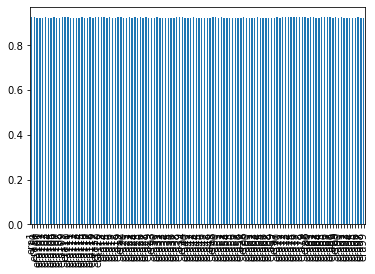

autocorrelation
0.17451960488942955
mean correlation
0.9243852982086129
sharpe
1391.2356071658694
smart sharpe
1163.2129178102707

Iteration 17:

fitting on worst eras
predicting on train


<ipython-input-13-9dfaa05d25fd>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.9258900984402735
0.9253589060235856
0.9244899065251383
0.9252691262584226
0.9255937657082153
0.9249335519013818
0.9242776996359315
0.9249986258648005
0.9251258924140967
0.9251548129511329
0.9248249199220593
0.9251127778389738
0.9248126135359498
0.9254846083789507
0.9246832109948249
0.9250068723762342
0.9240724455488805
0.9240624709184392
0.9257517586360905
0.9245062595608312
0.9246431612864519
0.9256085246112663
0.9245660590897247
0.9247938139294748
0.9246815669755073
0.9251035659570127
0.9241079976942864
0.9246754166634291
0.9238708675249044
0.9241036604239151
0.9248246311332032
0.9237486473838447
0.9230341513966762
0.9243229413163295
0.9237537795780771
0.9245686538603362
0.9244287195477804
0.9247401824286172
0.9247166173713608
0.924477676864259
0.9239378202239619
0.9236270924749588
0.924890828854667
0.9245041840005874
0.9233619558676867
0.9237939501175713
0.9233160371475686
0.9237669968508391
0.924420683801464
0.9247836593028302
0.9244383296198371
0.924761248

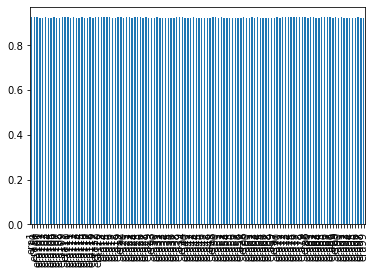

autocorrelation
0.17523550247503197
mean correlation
0.9244799831775531
sharpe
1437.5138590735057
smart sharpe
1201.0268144436986

Iteration 18:

fitting on worst eras


In [ ]:
X_train, y_train = clean_for_xgboost(pca_train)
boost_model = era_boost_train(X_train, y_train,
                              era_col=pca_train["era"], proportion=1.0,
                              trees_per_step=10, num_iters=20)

In [ ]:
tournament_calc = tournament_static.copy()
X_tournament, y_tournament = clean_for_xgboost(pca_tournament)
# dtournament = xgboost.DMatrix(X_tournament, y_tournament)
tournament_calc.loc[:,"prediction"] = boost_model.predict(X_tournament)
tournament_calc.set_index('id', inplace=True)
tournament_calc['prediction'].to_csv(f"era_boost_submission1.csv", header=True)

In [11]:
def train_model(train, model=None):
    X, y = clean_for_xgboost(train)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    dtrain = xgboost.DMatrix(X_train, y_train)
    dtest = xgboost.DMatrix(X_test, y_test)
    
#     dtrain, dtest = setup_xgboost_training(train)
    param = {
        'colsample_bytree': 0.7334,
        'gamma': 1.412,
        'max_depth': 10,
        'min_child_weight': 18.26,
        'subsample': 1.0,
        'eta': 0.05,
        'objective': 'reg:squarederror',
        'eval_metric':'rmse',
        'verbosity': 0
    }
    evals_result = {}
    
    if model is not None:
        tmodel = xgboost.train(
            params=param,
            dtrain=dtrain,
            feval=correlation_score,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dtest, 'test')],
            evals_result=evals_result,
            xgb_model=model,
            verbose_eval=10,
        )
    else:
        tmodel = xgboost.train(
            params=param,
            dtrain=dtrain,
            feval=correlation_score,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dtest, 'test')],
            evals_result=evals_result,
            verbose_eval=10,
        )

    hex_gen = uuid.uuid4()
    print(f"Hex number associated with this is {hex_gen}")
    save_model(model, f'model_{hex_gen}.pickle.dat')
    return tmodel

In [12]:
model = train_model(pca_train)

[1]	train-rmse:0.22312	train-pos_corr:0.05228	test-rmse:0.22369	test-pos_corr:0.01460
[2]	train-rmse:0.22311	train-pos_corr:0.05529	test-rmse:0.22369	test-pos_corr:0.01716
[3]	train-rmse:0.22309	train-pos_corr:0.06006	test-rmse:0.22368	test-pos_corr:0.01749
[4]	train-rmse:0.22308	train-pos_corr:0.06094	test-rmse:0.22368	test-pos_corr:0.01886
[5]	train-rmse:0.22306	train-pos_corr:0.06674	test-rmse:0.22367	test-pos_corr:0.02202
[6]	train-rmse:0.22305	train-pos_corr:0.06629	test-rmse:0.22367	test-pos_corr:0.02199
[7]	train-rmse:0.22304	train-pos_corr:0.06786	test-rmse:0.22367	test-pos_corr:0.02204
[8]	train-rmse:0.22302	train-pos_corr:0.07457	test-rmse:0.22367	test-pos_corr:0.02134
[9]	train-rmse:0.22301	train-pos_corr:0.07397	test-rmse:0.22366	test-pos_corr:0.02154
[11]	train-rmse:0.22299	train-pos_corr:0.07339	test-rmse:0.22365	test-pos_corr:0.02321
[12]	train-rmse:0.22298	train-pos_corr:0.07643	test-rmse:0.22365	test-pos_corr:0.02379
[13]	train-rmse:0.22296	train-pos_corr:0.07790	test-

[106]	train-rmse:0.22245	train-pos_corr:0.13175	test-rmse:0.22359	test-pos_corr:0.03179
[107]	train-rmse:0.22244	train-pos_corr:0.13242	test-rmse:0.22359	test-pos_corr:0.03144
[108]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[109]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[111]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[112]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[113]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[114]	train-rmse:0.22242	train-pos_corr:0.13439	test-rmse:0.22359	test-pos_corr:0.03145
[115]	train-rmse:0.22242	train-pos_corr:0.13499	test-rmse:0.22359	test-pos_corr:0.03140
[116]	train-rmse:0.22242	train-pos_corr:0.13499	test-rmse:0.22359	test-pos_corr:0.03140
[117]	train-rmse:0.22241	train-pos_corr:0.13574	test-rmse:0.22359	test-pos_corr:0.03134
[118]	train-rmse:0.22241	train-p

[211]	train-rmse:0.22211	train-pos_corr:0.15934	test-rmse:0.22358	test-pos_corr:0.03300
[212]	train-rmse:0.22210	train-pos_corr:0.16009	test-rmse:0.22358	test-pos_corr:0.03270
[213]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[214]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[215]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[216]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[217]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[218]	train-rmse:0.22209	train-pos_corr:0.16085	test-rmse:0.22358	test-pos_corr:0.03291
[219]	train-rmse:0.22209	train-pos_corr:0.16085	test-rmse:0.22358	test-pos_corr:0.03291
[221]	train-rmse:0.22209	train-pos_corr:0.16085	test-rmse:0.22358	test-pos_corr:0.03291
[222]	train-rmse:0.22209	train-pos_corr:0.16110	test-rmse:0.22358	test-pos_corr:0.03313
[223]	train-rmse:0.22208	train-p

[315]	train-rmse:0.22196	train-pos_corr:0.16978	test-rmse:0.22357	test-pos_corr:0.03349
[316]	train-rmse:0.22196	train-pos_corr:0.16978	test-rmse:0.22357	test-pos_corr:0.03349
[317]	train-rmse:0.22196	train-pos_corr:0.17005	test-rmse:0.22357	test-pos_corr:0.03362
[318]	train-rmse:0.22195	train-pos_corr:0.17030	test-rmse:0.22357	test-pos_corr:0.03373
[319]	train-rmse:0.22195	train-pos_corr:0.17030	test-rmse:0.22357	test-pos_corr:0.03373
[321]	train-rmse:0.22195	train-pos_corr:0.17013	test-rmse:0.22357	test-pos_corr:0.03374
[322]	train-rmse:0.22195	train-pos_corr:0.17013	test-rmse:0.22357	test-pos_corr:0.03374
[323]	train-rmse:0.22195	train-pos_corr:0.17013	test-rmse:0.22357	test-pos_corr:0.03374
[324]	train-rmse:0.22194	train-pos_corr:0.17041	test-rmse:0.22357	test-pos_corr:0.03385
[325]	train-rmse:0.22194	train-pos_corr:0.17041	test-rmse:0.22357	test-pos_corr:0.03385
[326]	train-rmse:0.22194	train-pos_corr:0.17081	test-rmse:0.22357	test-pos_corr:0.03398
[327]	train-rmse:0.22194	train-p

[419]	train-rmse:0.22183	train-pos_corr:0.17749	test-rmse:0.22357	test-pos_corr:0.03352
[421]	train-rmse:0.22183	train-pos_corr:0.17749	test-rmse:0.22357	test-pos_corr:0.03352
[422]	train-rmse:0.22183	train-pos_corr:0.17749	test-rmse:0.22357	test-pos_corr:0.03352
[423]	train-rmse:0.22183	train-pos_corr:0.17781	test-rmse:0.22358	test-pos_corr:0.03336
[424]	train-rmse:0.22183	train-pos_corr:0.17781	test-rmse:0.22358	test-pos_corr:0.03336
[425]	train-rmse:0.22183	train-pos_corr:0.17781	test-rmse:0.22358	test-pos_corr:0.03336
[426]	train-rmse:0.22182	train-pos_corr:0.17827	test-rmse:0.22357	test-pos_corr:0.03349
[427]	train-rmse:0.22182	train-pos_corr:0.17827	test-rmse:0.22357	test-pos_corr:0.03349
[428]	train-rmse:0.22182	train-pos_corr:0.17827	test-rmse:0.22357	test-pos_corr:0.03349
[429]	train-rmse:0.22182	train-pos_corr:0.17832	test-rmse:0.22357	test-pos_corr:0.03344
[431]	train-rmse:0.22182	train-pos_corr:0.17832	test-rmse:0.22357	test-pos_corr:0.03344
[432]	train-rmse:0.22182	train-p

[524]	train-rmse:0.22174	train-pos_corr:0.18338	test-rmse:0.22358	test-pos_corr:0.03306
[525]	train-rmse:0.22174	train-pos_corr:0.18338	test-rmse:0.22358	test-pos_corr:0.03306
[526]	train-rmse:0.22173	train-pos_corr:0.18399	test-rmse:0.22358	test-pos_corr:0.03306
[527]	train-rmse:0.22173	train-pos_corr:0.18421	test-rmse:0.22358	test-pos_corr:0.03301
[528]	train-rmse:0.22173	train-pos_corr:0.18421	test-rmse:0.22358	test-pos_corr:0.03301
[529]	train-rmse:0.22173	train-pos_corr:0.18432	test-rmse:0.22358	test-pos_corr:0.03311
[531]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[532]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[533]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[534]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[535]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[536]	train-rmse:0.22172	train-p

[628]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[629]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[631]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[632]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[633]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[634]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[635]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[636]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[637]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[638]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[639]	train-rmse:0.22167	train-pos_corr:0.18765	test-rmse:0.22358	test-pos_corr:0.03307
[641]	train-rmse:0.22167	train-p

[733]	train-rmse:0.22157	train-pos_corr:0.19348	test-rmse:0.22358	test-pos_corr:0.03286
[734]	train-rmse:0.22157	train-pos_corr:0.19348	test-rmse:0.22358	test-pos_corr:0.03286
[735]	train-rmse:0.22157	train-pos_corr:0.19348	test-rmse:0.22358	test-pos_corr:0.03286
[736]	train-rmse:0.22157	train-pos_corr:0.19382	test-rmse:0.22359	test-pos_corr:0.03259
[737]	train-rmse:0.22156	train-pos_corr:0.19392	test-rmse:0.22359	test-pos_corr:0.03250
[738]	train-rmse:0.22156	train-pos_corr:0.19392	test-rmse:0.22359	test-pos_corr:0.03250
[739]	train-rmse:0.22156	train-pos_corr:0.19392	test-rmse:0.22359	test-pos_corr:0.03250
[741]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[742]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[743]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[744]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[745]	train-rmse:0.22156	train-p

[837]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[838]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[839]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[841]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[842]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[843]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[844]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[845]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[846]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[847]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[848]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[849]	train-rmse:0.22148	train-p

[942]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[943]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[944]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[945]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[946]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[947]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[948]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[949]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[951]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[952]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[953]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[954]	train-rmse:0.22147	train-p

In [13]:
save_model(model, 'model2.pkl')

In [107]:
submissions = []
X_tournament, y_tournament = clean_for_xgboost(pca_tournament)
dtournament = xgboost.DMatrix(X_tournament, y_tournament)
# model_name = 'boomkin'
# model_id = '6bd2c44b-38bb-4918-9f08-cc1e880bc6a5'
# model = load_model(f'models/{model_name}/model_{model_id}.pickle.dat')
pca_tournament.loc[:,"prediction"] = model.predict(dtournament)
submissions.append(pca_tournament)
generate_submission(pca_tournament, name=f'model_{model_name}_submission.csv')

In [33]:
def neutralize(series, by, proportion):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack((exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized

by = pd.read_csv('data/numerai_dataset_'+str(NAPI.get_current_round())+'/example_predictions.csv')
neut = pd.DataFrame({'prediction': neutralize(pca_tournament['prediction'], by['prediction'], 0.3)})

conc = pd.concat([by.drop(columns="prediction"),neut], axis=1)
conc.to_csv("neutralized_model_boomkin_submission.csv", index=False) # submission file

<ipython-input-33-e06180fd2d06>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))


In [42]:
sum(n < 0 for n in conc.prediction.values.flatten())
num = conc._get_numeric_data()
num[num < 0] = 0

0

In [53]:
def correlation_score(preds, dtrain):
    return "corr", np.corrcoef(preds, dtrain.get_label())[0,1]

In [ ]:
X_tournament, y_tournament = clean_for_xgboost(pca_tournament)
dtournament = xgboost.DMatrix(X_tournament, y_tournament)

In [101]:
def train_test_dataframe(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    test = df[~msk]
    return train, test

In [109]:
grouped = pca_train.groupby('era')
for name, group in grouped:
    train, test = train_test_dataframe(group)
    print("Current era", name)
    model = None
    model = train_model(train, test, model)

Current era era1
[1]	train-logloss:0.69314	test-logloss:0.69316
[2]	train-logloss:0.69314	test-logloss:0.69317
[3]	train-logloss:0.69314	test-logloss:0.69317
[4]	train-logloss:0.69314	test-logloss:0.69318
[5]	train-logloss:0.69314	test-logloss:0.69318
[6]	train-logloss:0.69314	test-logloss:0.69319
[7]	train-logloss:0.69314	test-logloss:0.69319
[8]	train-logloss:0.69314	test-logloss:0.69320
[9]	train-logloss:0.69314	test-logloss:0.69320
[11]	train-logloss:0.69279	test-logloss:0.69313
[12]	train-logloss:0.69279	test-logloss:0.69314
[13]	train-logloss:0.69279	test-logloss:0.69314
[14]	train-logloss:0.69279	test-logloss:0.69315
[15]	train-logloss:0.69279	test-logloss:0.69315
[16]	train-logloss:0.69279	test-logloss:0.69315
[17]	train-logloss:0.69279	test-logloss:0.69316
[18]	train-logloss:0.69279	test-logloss:0.69316
[19]	train-logloss:0.69279	test-logloss:0.69316
[21]	train-logloss:0.69279	test-logloss:0.69317
[22]	train-logloss:0.69279	test-logloss:0.69317
[23]	train-logloss:0.69279	test-

KeyboardInterrupt: 

In [108]:
save_model(model, f'model_boomkin_testing_logloss_1000.pickle.dat')

In [48]:
def hyp_xgb(max_depth, subsample, colsample_bytree, min_child_weight, gamma):
    params = {
      'eta': 0.05,
      'objective': 'reg:squarederror',
      'eval_metric':'logloss', # Optional --> Use eval_metric if you want to stop evaluation based on eval_metric 
      'verbosity': 0
    }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    
    scores = xgboost.cv(params,
                    dtrain,
                    num_boost_round=10,
                    verbose_eval=False,
                    early_stopping_rounds=5,
                    feval=correlation_score,
                    maximize=True,
                    nfold=5)
    return  scores['test-corr-mean'].iloc[-1]
pds ={
  'min_child_weight':(14, 20),
  'gamma':(0, 5),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (5, 10)
}

In [ ]:
X_train, y_train = clean_for_xgboost(pca_train)
dtrain = xgboost.DMatrix(X_train, y_train)

In [54]:
# Surrogate model
optimizer = BayesianOptimization(hyp_xgb, pds, random_state=101)                   
# Optimize
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.02035  |  0.5648   |  2.853    |  5.142    |  15.03    |  0.8426   |
|  2        |  0.02446  |  0.8505   |  1.535    |  9.468    |  18.33    |  0.595    |
|  3        |  0.02291  |  0.5988   |  1.761    |  5.909    |  18.71    |  0.9827   |
|  4        |  0.01973  |  0.3091   |  0.4178   |  8.018    |  18.37    |  0.6381   |
|  5        |  0.01749  |  0.7168   |  2.589    |  5.242    |  14.83    |  0.5935   |
|  6        |  0.02388  |  0.7079   |  1.778    |  5.855    |  18.67    |  0.7764   |
|  7        |  0.02366  |  0.9361   |  1.604    |  9.371    |  18.53    |  0.6457   |
|  8        |  0.02189  |  0.8296   |  1.917    |  10.0     |  18.0     |  0.5314   |
|  9        |  0.0202   |  0.5885   |  2.221    |  7.087    |  16.12    |  0.5198   |
|  10       |  0.02263  |  0.9528   |  0.9688   |  9.5

In [ ]:
|  18       |  0.02606  |  0.7334   |  1.412    |  9.64     |  18.26    |  1.0      |
|  14       |  0.02553  |  0.5      |  1.431    |  9.719    |  18.5     |  0.865    |
|  2        |  0.02446  |  0.8505   |  1.535    |  9.468    |  18.33    |  0.595    |